# Import Modules

In [2]:
import pandas 
import re
import nltk
from langdetect import detect
import matplotlib.pyplot as plt

# Fetch Dataset

In [75]:
#current directory containing dataset
directory = "Dataset/"

#read training set
#train_csv = pandas.read_csv(directory+"mediaeval-2015-trainingset.txt", sep="	")
#train_df = pandas.DataFrame(data = train_csv)

#read test set
#test_csv = pandas.read_csv(directory+"mediaeval-2015-testset.txt", sep="	")
#test_df = pandas.DataFrame(data = test_csv)


train_df = pandas.read_table("Dataset/mediaeval-2015-trainingset.txt", sep="\t",lineterminator='\n', skiprows=(0),  header=(0))
test_df = pandas.read_table("Dataset/mediaeval-2015-testset.txt", sep="\t", lineterminator='\n', skiprows=(0),  header=(0))




# Data Characterisation

In [60]:
#Dataset information, mainly different fields and size
train_df.info()
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64

In [61]:
#shape of training/test sets
print(train_df.shape)
print(test_df.shape)

(14277, 7)
(3755, 7)


In [76]:
#example of dataset entities
train_df.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [77]:
#renaming ImageId(s) as clunky column name
train_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)

test_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)


Train:
imageId
sandyA                9696
sandyB                2622
boston                 546
malaysia               501
sochi                  402
columbianChemicals     185
bringback              131
underwater             112
passport                46
pigFish                 14
elephant                13
livr                     9
Name: count, dtype: int64


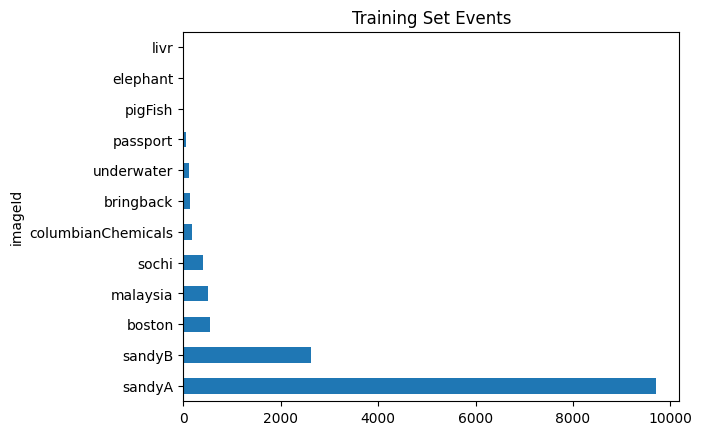

In [78]:
#events categorised by ImageID (train)
print("Train:")
selected_events = train_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Training Set Events")
plt.show()



Test:
imageId
syrianboy     1769
nepal         1353
eclipse        277
samurai        218
garissa         77
varoufakis      61
Name: count, dtype: int64


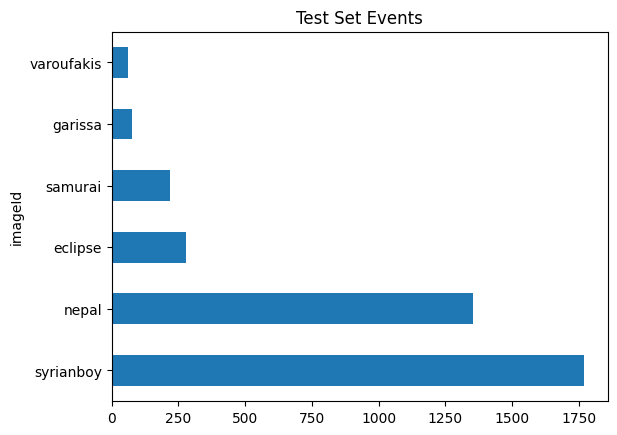

In [79]:
#events categorised by ImageID (test)
print("Test:")
selected_events = test_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Test Set Events")
plt.show()

In [80]:
#example tweets for different events

event = "sandy" #change variable for different events

total_df = train_df + test_df
selected_tweets = total_df[total_df["imageId"].str.contains(event, na=False)]["tweetText"].head(30)
print(selected_tweets)

0     ¿Se acuerdan de la película: “El día después d...
1     @milenagimon: Miren a Sandy en NY!  Tremenda i...
2     Buena la foto del Huracán Sandy, me recuerda a...
3     Scary shit #hurricane #NY http://t.co/e4JLBUfH...
4     My fave place in the world #nyc #hurricane #sa...
5     42nd #time #square #NYC #subway #hurricane htt...
6     Just in time for #halloween a photo of #hurric...
7     Crazy pic of #Hurricane #Sandy prayers go out ...
8     #sandy #newyork #hurricane #statueofliberty #U...
9     #nyc #hurricane http://t.co/Gv3QxZlqPhoto: The...
10    robertosalibaba  god be with u brother #sandy ...
11    #Crazy #Hurricane #Sandy http://t.co/0zrMsgvs“...
12    #shark #newjersey #swim #sandy #hurricane  ...
13    Good luck #ny #newyork #usa #hurricane #sandy ...
14    Wow.... Fishing anyone? #hurricane #sandy http...
15    Well #howdy there #hurricane #sandy . Just wan...
16    Just known this bcs of #jason #chen updated th...
17    My thoughts and prayers go to all of the p

{'es': 1292, 'en': 10942, 'sq': 7, 'ru': 60, 'it': 103, 'no': 37, 'fr': 217, 'bg': 8, 'nl': 89, 'pt': 162, 'de': 127, 'tl': 327, 'cy': 115, 'id': 181, 'ja': 20, 'ar': 81, 'vi': 13, 'ca': 35, 'hu': 6, 'sv': 46, 'so': 117, 'et': 11, 'fi': 13, 'pl': 34, 'sk': 17, 'da': 31, 'af': 75, 'el': 5, 'lt': 4, 'he': 1, 'ko': 7, 'hr': 4, 'tr': 31, 'zh-cn': 9, 'ro': 5, 'fa': 3, 'sl': 8, 'sw': 9, 'th': 19, 'cs': 2, 'Unknown': 1, 'mk': 1, 'hi': 1, 'lv': 1}


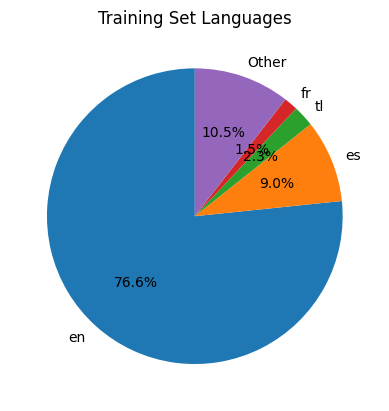

In [20]:
#number of languages in training set
trainLangs = {}

for text in train_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    trainLangs[lan] = trainLangs.get(lan, 0) + 1
  
print(trainLangs)

# top 4 languages 
top_langs = dict(sorted(trainLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(trainLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Training Set Languages")
plt.show()



{'en': 2776, 'fr': 33, 'es': 63, 'ca': 7, 'it': 18, 'pt': 33, 'nl': 21, 'fi': 4, 'id': 7, 'ar': 182, 'af': 4, 'sq': 4, 'hr': 1, 'tr': 12, 'hi': 5, 'ta': 1, 'el': 2, 'tl': 2, 'pl': 2, 'te': 2, 'ru': 1, 'th': 2, 'sv': 3, 'et': 1, 'so': 515, 'bg': 2, 'vi': 2, 'ko': 1, 'ja': 2, 'cy': 5, 'lt': 1, 'de': 41}


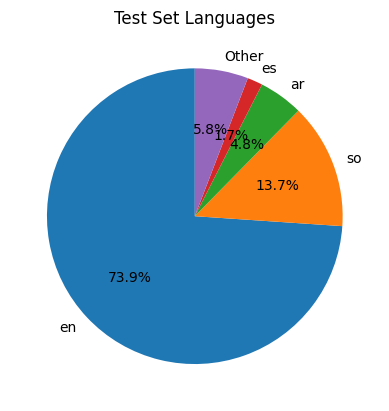

In [12]:
#number of languages in test set
testLangs = {}

for text in test_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    testLangs[lan] = testLangs.get(lan, 0) + 1
  

print(testLangs)

# top 4 languages 
top_langs = dict(sorted(testLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(testLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Test Set Languages")
plt.show()



In [81]:
#Searching for duplicate tweets in training
print(train_df["tweetText"].describe())
print(f"duplicates:  {train_df['tweetText'].duplicated().sum()}")



count                                                 14277
unique                                                12376
top       Unbelievable scene flying over #StatenIsland i...
freq                                                     42
Name: tweetText, dtype: object
duplicates:  1901


In [82]:
#Searching for duplicate tweets in test
print(test_df["tweetText"].describe())
print(f"duplicates:  {test_df['tweetText'].duplicated().sum()}")

count                                                  3755
unique                                                 3706
top       J'aime une vidéo @YouTube : "SYRIA! SYRIAN HER...
freq                                                      4
Name: tweetText, dtype: object
duplicates:  49


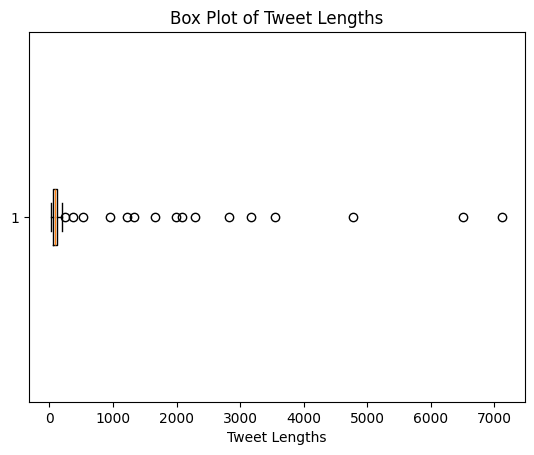

Highest Reasonable Value: 190.0


In [86]:
#compare lengths of tweets in training
train_df["tweetLength"] = train_df["tweetText"].apply(len)

bp = plt.boxplot(train_df["tweetLength"], vert=False)

max_legit_value = bp["whiskers"][1].get_data()[0][1]

plt.title("Box Plot of Tweet Lengths")
plt.xlabel("Tweet Lengths")
plt.show()

print(f"Highest Reasonable Value: {max_legit_value}")

In [105]:
#investigate 16 outliers
top_indices = train_df["tweetLength"].nlargest(16).index
longest_tweets = train_df.loc[top_indices, "tweetText"]
#print(longest_tweets)

#used to debug longest tweet cause
n = 3
print(f"Longest Tweet:\n{longest_tweets.values[n]}\nLength: {len(longest_tweets.values[n])}")


Longest Tweet:
Where that pic taken? RT @DaQueennnBee: My prayers \355\240\275\355\271\217 are with the ppl affected by #hurricane #sandy #godbless http://t.co/Pa4SBxnV
Length: 153


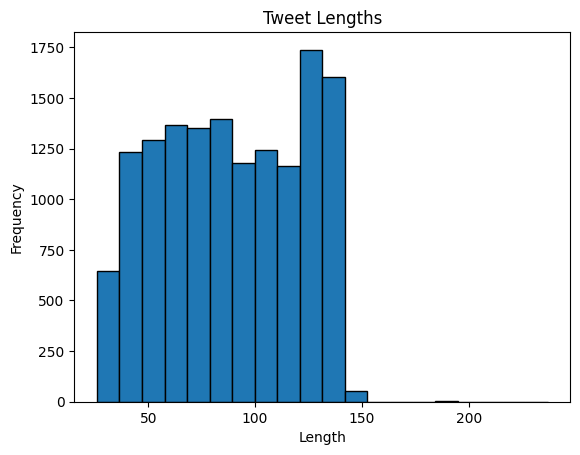

In [97]:
#Above process confirms that the 15th longest tweet 
#(according to the box plot) is actually the correct longest tweet

#removing 14 outliers containing multiple tweets (tweets longer than 237)
train_df = train_df[train_df["tweetLength"] < 238]

#new distribution of tweet lengths
plt.hist(train_df["tweetLength"], bins=20, edgecolor='black')

plt.title("Tweet Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Data Preprocessing

## Plan

### Both pipelines

- Change humor to fake
- Remove URLs
- Remove certain punctiation
- Remove whitespace and stopwords 
- Tokenise

### Just Pipeline 2 (draft)

- Remove re-tweets and reposts
- Remove usernames
- Remove emojis
- Don't remove #
- Don't remove URLS





In [85]:
#replace 'humor' label with 'fake'
train_df['label'] = train_df['label'].replace('humor', 'fake')
test_df['label'] = test_df['label'].replace('humor', 'fake')


In [86]:
#remove URLs
train_df['tweetText'] = train_df['tweetText'].apply(lambda x: re.sub(r'http\S+|\\\/\S+', '', x))


# Model Desgin

# Model Training and Testing

# Evaluation